## 1. Постановка задачи

Необходимо построить модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
import category_encoders as ce

Прочитаем наш файл с исходными данными:

In [65]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [66]:
# ваш код здесь

taxi_data['pickup_datetime']= pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print(f"Данные охватывают период с {taxi_data['pickup_datetime'].min().date()} по {taxi_data['pickup_datetime'].max().date()}")

Данные охватывают период с 2016-01-01 по 2016-06-30


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [67]:
# ваш код здесь
# проверяем датасет на наличие пропусков
# taxi_data.info()

sum_isnull= taxi_data.isnull().sum().sum()

print('Сумма пропущенных значений в dataframe', sum_isnull)

Сумма пропущенных значений в dataframe 0


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [68]:
# ваш код здесь
unique_park= len(taxi_data['vendor_id'].unique())
max_passenger= taxi_data['passenger_count'].max()
mean_trip_rucation= round(taxi_data['trip_duration'].mean())
median_trip_rucation= round(taxi_data['trip_duration'].median())
min_trip_rucation= round(taxi_data['trip_duration'].min())
max_trip_rucation= round(taxi_data['trip_duration'].max())

print('Количество уникальных таксопарков в DataFrame' , unique_park)
print('Максимальное количество пассажиров в транспортном средстве:' , max_passenger)
print('Средняя и медианная длительность поездки:' ,mean_trip_rucation, 'и ' ,median_trip_rucation)
print('Минимальное и максимальное время поездки (в секундах)', min_trip_rucation, 'и ', max_trip_rucation )


Количество уникальных таксопарков в DataFrame 2
Максимальное количество пассажиров в транспортном средстве: 9
Средняя и медианная длительность поездки: 959 и  662
Минимальное и максимальное время поездки (в секундах) 1 и  3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [69]:
# ваш код здесь

def add_datetime_features(df):
    # Извлекаем компоненты
    df['pickup_date']=  pd.to_datetime(df['pickup_datetime']).dt.date
    df['pickup_hour']= pd.to_datetime(df['pickup_datetime']).dt.hour
    df['pickup_day_of_week']= pd.to_datetime(df['pickup_datetime']).dt.day_of_week
    # возвращаем датафрейм 
    return df
    
# применчем  функцию к нашему датафрейму
taxi_data= add_datetime_features(taxi_data)
# taxi_data['pickup_day_of_week']
saturday_trip= len(taxi_data[taxi_data['pickup_day_of_week'] == 5])
print('Количество поездок совершеных в субботу', saturday_trip)

# Группируем по дате и считаем количество поездок
daily_trips = taxi_data.groupby('pickup_date').size()
# Вычисляем среднее
mean_daily_trips = daily_trips.mean()
print(f'Среднее количество поездок в день: {mean_daily_trips:.0f}')

Количество поездок совершеных в субботу 220868
Среднее количество поездок в день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [70]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')

# ваш код здесь
def add_holiday_features(df, holiday_data):
    # Преобразуем даты праздников в тот же тип, что и pickup_date
    holidays = pd.to_datetime(holiday_data['date']).dt.date
    # Создаём столбец-индикатор
    df['pickup_holiday'] = df['pickup_date'].isin(holidays).astype(int)
    return df

taxi_data= add_holiday_features(taxi_data, holiday_data)

holiday_trips = taxi_data[taxi_data['pickup_holiday'] == 1]
median_trip_duration_holiday = holiday_trips['trip_duration'].median()
print('Медианная длительность поездки в праздники:', median_trip_duration_holiday)



Медианная длительность поездки в праздники: 585.0


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [71]:
osrm_data = pd.read_csv('osrm_data_train.csv')

# ваш код здесь
def add_osrm_features(df, osrm_data):
    
    # Выбираем только нужные столбцы из osrm_data
    osrm_subset = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    
    # Выполняем левое соединение по id, чтобы сохранить все записи из df
    df_updated = df.merge(osrm_subset, on='id', how='left')
    
    return df_updated
# применяем метод 
taxi_data= add_osrm_features(taxi_data,osrm_data )

diff_median_trip= taxi_data['trip_duration'].median()- taxi_data['total_travel_time'].median()
rows_with_na = taxi_data.isnull().any(axis=1).sum()

print('Разница в секундах между медианной длительноостью поездок:' ,diff_median_trip)
print('Сумма cтрок с пропусками  в DF после обьединения таблиц:', rows_with_na)


Разница в секундах между медианной длительноостью поездок: 372.5
Сумма cтрок с пропусками  в DF после обьединения таблиц: 1


In [72]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [73]:
# ваш код здесь

def add_geographical_features(df): 
    # извлекаем координаты 
    lat1= df['pickup_latitude']
    lng1= df['pickup_longitude']
    lat2= df['dropoff_latitude']
    lng2= df['dropoff_longitude']
    df['haversine_distance']= get_haversine_distance(lat1, lng1, lat2, lng2)
    df['direction']=get_angle_direction(lat1, lng1, lat2, lng2)
    return df

taxi_data= add_geographical_features(taxi_data)
median_haversine_distance= round(taxi_data['haversine_distance'].median(), 2)
print('Медианное расстояние Хаверсина поездок (в киллометрах) равно:', median_haversine_distance )

Медианное расстояние Хаверсина поездок (в киллометрах) равно: 2.09


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [74]:
# ваш код здесь
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)
def add_cluster_features(df, kmeans):

    df['geo_cluster']= kmeans.predict(coords)
    return df


taxi_data= add_cluster_features(taxi_data,kmeans )

min_cluster_size = taxi_data['geo_cluster'].value_counts().min()
print('Количество поездоу в наименьшем по размеру географическом кластере', min_cluster_size)


Количество поездоу в наименьшем по размеру географическом кластере 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [75]:
weather_data = pd.read_csv('weather_data.csv')

# ваш код здесь

def add_weather_features(df, weather_data):
    # Приводим время к datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    weather_data['time'] = pd.to_datetime(weather_data['time'])
    feature= weather_data[['temperature', 'visibility' , 'wind speed','precip' ,'events', 'time']]
    # Округляем время посадки до часа
    df['pickup_hour_01'] = df['pickup_datetime'].dt.floor('h')

    # Левое слияние с погодой по часу
    df = df.merge(feature, left_on='pickup_hour_01', right_on='time', how='left')

    # Удаляем служебные столбцы, если нужно
    df.drop(columns=['pickup_hour_01', 'time'], inplace=True)

    # Возвращаем df с добавленными погодными столбцами
    return df
# применяем нашу функцию 
taxi_data= add_weather_features(taxi_data , weather_data)
#  ищем кол-во поездок в снежную погоду 
snow_trips = taxi_data[taxi_data['events'].str.contains('Snow', na=False, case=False)].shape[0]
print('Количество поездок совершеных в снежную погоду:',snow_trips)  #выводим результат

# считаем долю пропусков в данных с погодными условиями 
total_rows = len(taxi_data)
missing_count = taxi_data['temperature'].isna().sum()
missing_percent = (missing_count / total_rows) * 100
print(f"Процент пропусков  в таблице с данными о поездках в столбцах с погодными условиями {missing_percent:.2f}%")

Количество поездок совершеных в снежную погоду: 13126
Процент пропусков  в таблице с данными о поездках в столбцах с погодными условиями 0.82%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [76]:
# ваш код здесь


def fill_null_weather_data(df):

    # Список погодных столбцов для заполнения
    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip']

    # Заполняем пропуски в погодных данных медианой по дате
    for col in weather_cols:
        df[col] = df.groupby('pickup_date')[col].transform(lambda x: x.fillna(x.median()))

    # Заменяем пропуски в событиях на 'None'
    df['events'] = df['events'].fillna('None')

    # Список OSRM-столбцов
    osrm_cols = ['total_distance', 'total_travel_time', 'number_of_steps']

    # Заполняем пропуски в OSRM медианой по дате
    for col in osrm_cols:
        df[col] = df.groupby('pickup_date')[col].transform(lambda x: x.fillna(x.median()))

    return df
taxi_data = fill_null_weather_data(taxi_data)
median_temp= taxi_data['temperature'].median()


print('Медиана в столбце temperature после заполнения пропусков равна:', median_temp)

Медиана в столбце temperature после заполнения пропусков равна: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


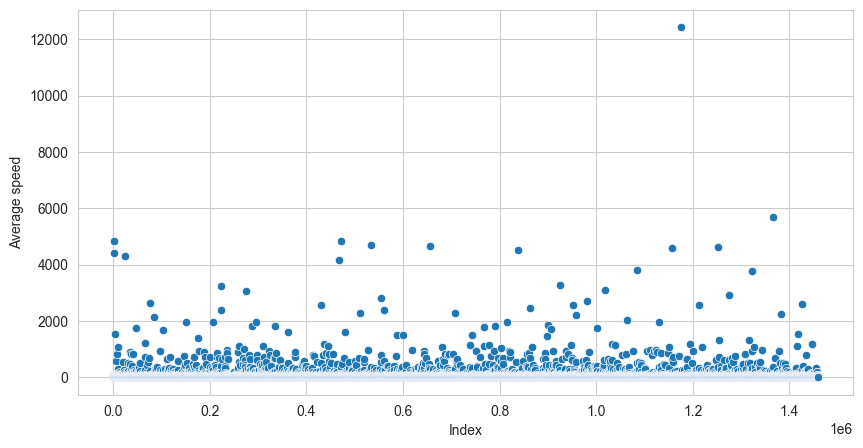

In [77]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [78]:
# ваш код здесь
# Длительность больше 24 часов
outliers_time_trip = len(taxi_data[taxi_data['trip_duration'] >= 86400])
print('Поездки, длительность которых превышает 24 часа:', outliers_time_trip, 'шт')

# Скорость > 300 км/ч (выбросы)
outliers_avg_speed = (avg_speed > 300).sum()
print('Поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч:', outliers_avg_speed, 'шт.')

# Удаляем выбросы (создаём чистый датасет)
mask = (taxi_data['trip_duration'] < 86400) & (avg_speed <= 300)
taxi_data = taxi_data[mask].copy()

Поездки, длительность которых превышает 24 часа: 4 шт
Поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч: 407 шт.


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [79]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

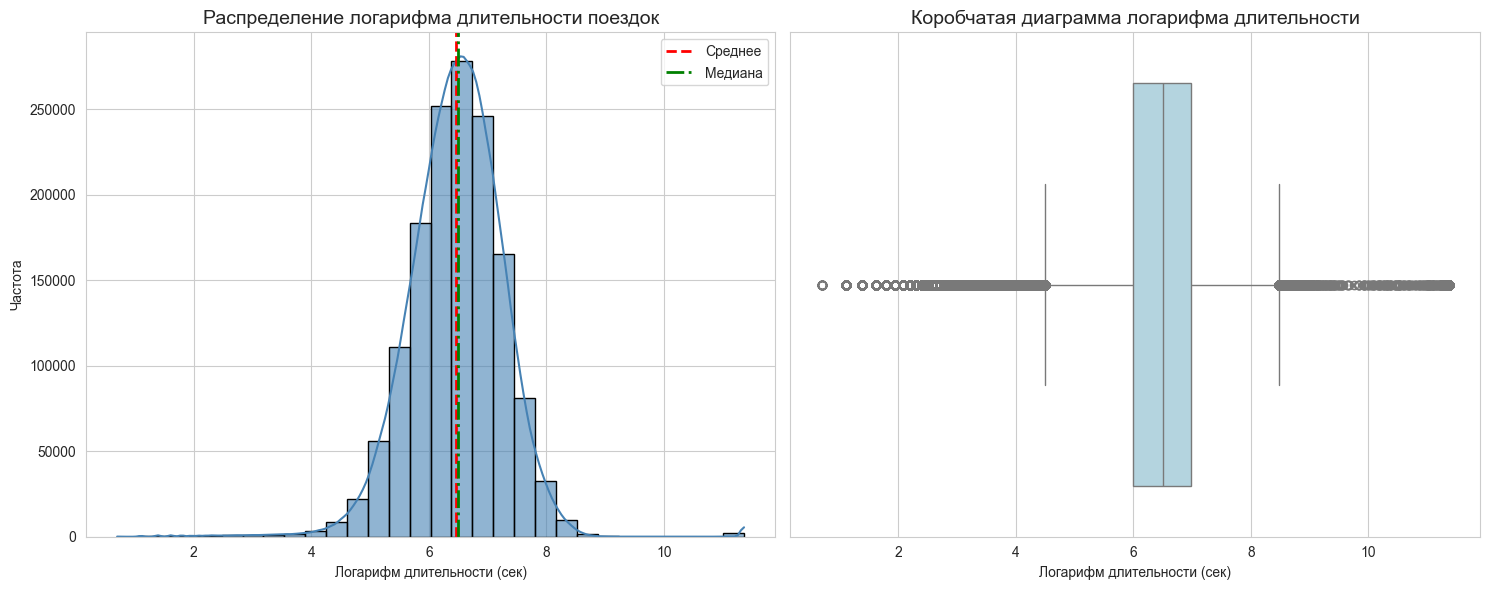

p-value = 0.00


In [80]:
# ваш код здесь


# Настройка стиля
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

# Создаём фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Гистограмма с KDE
sns.histplot(data=taxi_data, x='trip_duration_log', bins=30, kde=True,
             color='steelblue', edgecolor='black', alpha=0.6, ax=axes[0])


axes[0].axvline(taxi_data['trip_duration_log'].mean(), color='red',
                linestyle='--', linewidth=2, label='Среднее')

axes[0].axvline(taxi_data['trip_duration_log'].median(), color='green',
                linestyle='-.', linewidth=2, label='Медиана')

axes[0].set_title('Распределение логарифма длительности поездок', fontsize=14)
axes[0].set_xlabel('Логарифм длительности (сек)')
axes[0].set_ylabel('Частота')
axes[0].legend()

# 2. Коробчатая диаграмма (boxplot)
sns.boxplot(data=taxi_data, x='trip_duration_log', color='lightblue', ax=axes[1])
axes[1].set_title('Коробчатая диаграмма логарифма длительности', fontsize=14)
axes[1].set_xlabel('Логарифм длительности (сек)')

plt.tight_layout()
plt.show()

# Тест на нормальность Д'Агостино-Пирсона
stat, p_value = stats.normaltest(taxi_data['trip_duration_log'].dropna())
print(f"p-value = {p_value:.2f}")

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

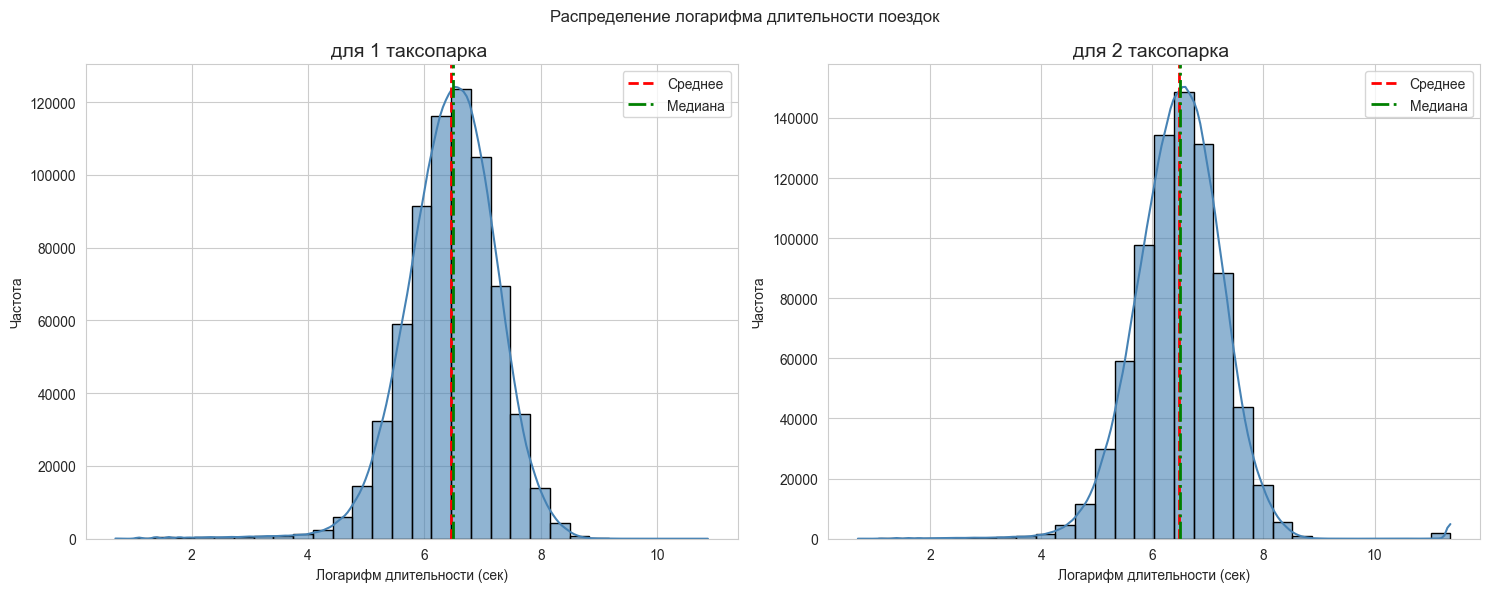

In [81]:
# ваш код здесь

# Настройка стиля
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
# задаем фильтры 
one_vendor_id= taxi_data[taxi_data['vendor_id']==1]
two_vendor_id= taxi_data[taxi_data['vendor_id']==2]
# Создаём фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=one_vendor_id, x='trip_duration_log', bins=30, kde=True,
             color='steelblue', edgecolor='black', alpha=0.6, ax=axes[0])


axes[0].axvline(one_vendor_id['trip_duration_log'].mean(), color='red',
                linestyle='--', linewidth=2, label='Среднее')

axes[0].axvline(one_vendor_id['trip_duration_log'].median(), color='green',
                linestyle='-.', linewidth=2, label='Медиана')

axes[0].set_title('для 1 таксопарка ', fontsize=14)
axes[0].set_xlabel('Логарифм длительности (сек)')
axes[0].set_ylabel('Частота')
axes[0].legend()


sns.histplot(data=two_vendor_id, x='trip_duration_log', bins=30, kde=True,
             color='steelblue', edgecolor='black', alpha=0.6, ax=axes[1])


axes[1].axvline(two_vendor_id['trip_duration_log'].mean(), color='red',
                linestyle='--', linewidth=2, label='Среднее')

axes[1].axvline(two_vendor_id['trip_duration_log'].median(), color='green',
                linestyle='-.', linewidth=2, label='Медиана')

axes[1].set_title('для 2 таксопарка ', fontsize=14)
axes[1].set_xlabel('Логарифм длительности (сек)')
axes[1].set_ylabel('Частота')
axes[1].legend()
fig.suptitle('Распределение логарифма длительности поездок')

plt.tight_layout()
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

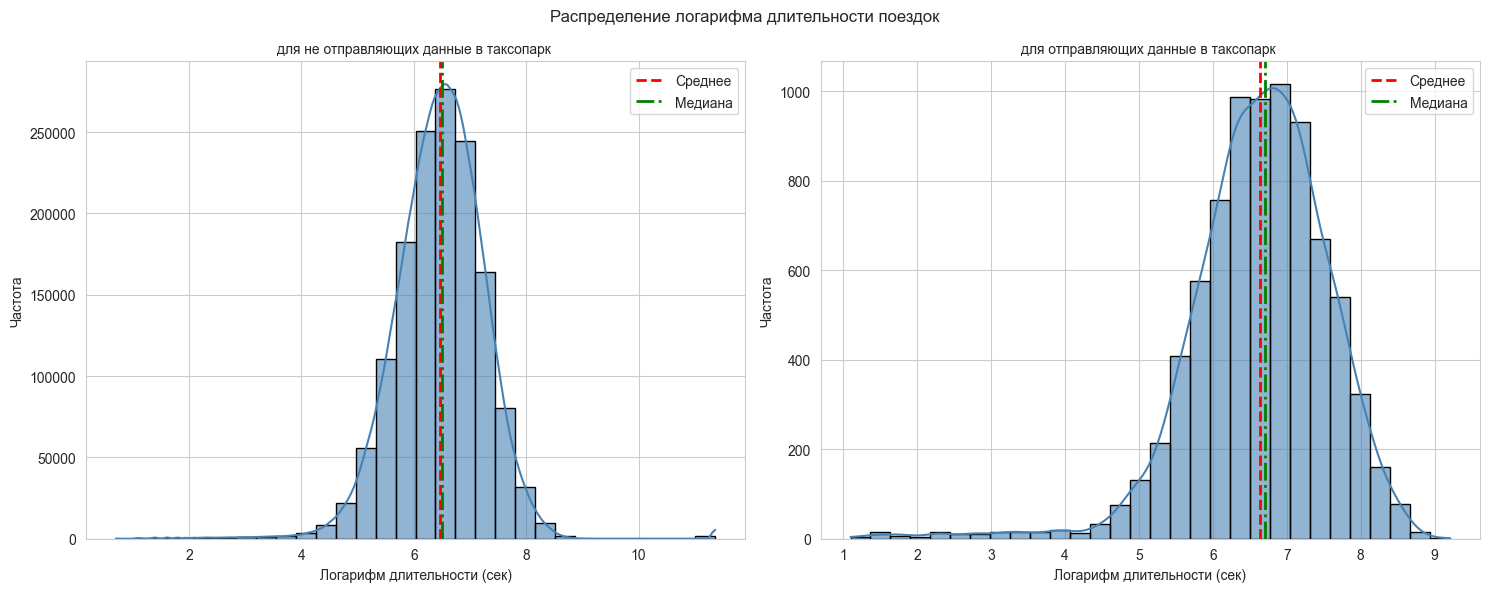

In [82]:
# ваш код здесь
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
# задаем фильтры 
not_sent_to_vendor= taxi_data[taxi_data['store_and_fwd_flag']=='N']
yes_sent_to_vendor= taxi_data[taxi_data['store_and_fwd_flag']=='Y']
# Создаём фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=not_sent_to_vendor, x='trip_duration_log', bins=30, kde=True,
             color='steelblue', edgecolor='black', alpha=0.6, ax=axes[0])


axes[0].axvline(not_sent_to_vendor['trip_duration_log'].mean(), color='red',
                linestyle='--', linewidth=2, label='Среднее')

axes[0].axvline(not_sent_to_vendor['trip_duration_log'].median(), color='green',
                linestyle='-.', linewidth=2, label='Медиана')

axes[0].set_title('для не отправляющих данные в таксопарк ', fontsize=10)
axes[0].set_xlabel('Логарифм длительности (сек)')
axes[0].set_ylabel('Частота')
axes[0].legend()


sns.histplot(data=yes_sent_to_vendor, x='trip_duration_log', bins=30, kde=True,
             color='steelblue', edgecolor='black', alpha=0.6, ax=axes[1])


axes[1].axvline(yes_sent_to_vendor['trip_duration_log'].mean(), color='red',
                linestyle='--', linewidth=2, label='Среднее')

axes[1].axvline(yes_sent_to_vendor['trip_duration_log'].median(), color='green',
                linestyle='-.', linewidth=2, label='Медиана')

axes[1].set_title('для отправляющих данные в таксопарк ', fontsize=10)
axes[1].set_xlabel('Логарифм длительности (сек)')
axes[1].set_ylabel('Частота')
axes[1].legend()
fig.suptitle('Распределение логарифма длительности поездок')

plt.tight_layout()
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

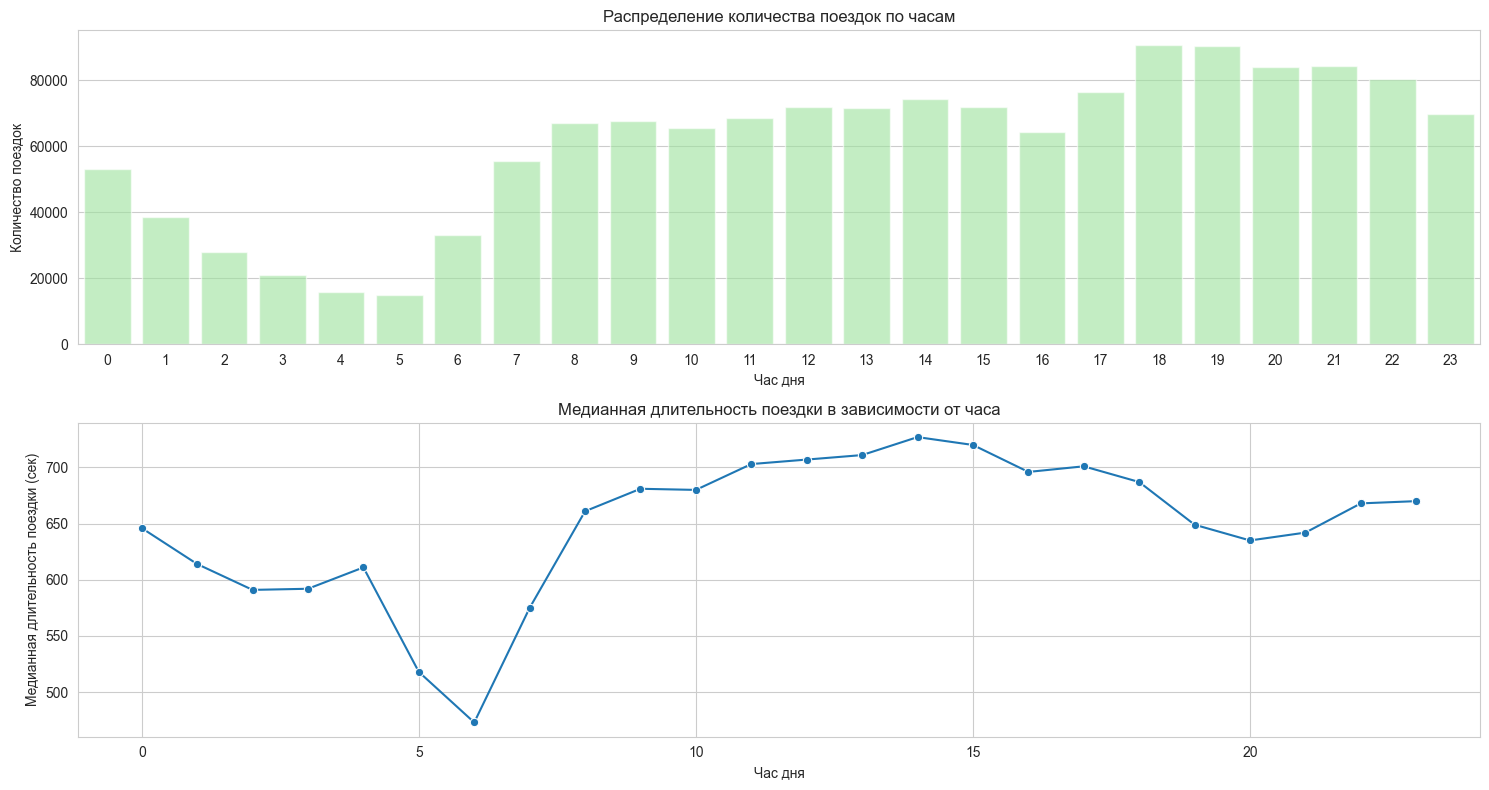

In [83]:
# ваш код здесь

# Вычисляем медианную длительность поездки для каждого часа
median_by_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median().reset_index()
median_by_hour.columns = ['pickup_hour', 'median_duration']

# Создаём фигуру с двумя подграфиками
fig, axes= plt.subplots(2,1, figsize=(15,8))

# 1. Распределение количества поездок по часам

sns.countplot(data=taxi_data, x='pickup_hour', color='lightgreen', alpha=0.6, ax=axes[0])
axes[0].set_xlabel('Час дня')
axes[0].set_ylabel('Количество поездок')
axes[0].set_title('Распределение количества поездок по часам')

# 2. Зависимость медианной длительности от часа
# sns.barplot(data=median_by_hour, x='pickup_hour', y='median_duration', color='lightblue', ax=axes[1])
sns.lineplot(data=median_by_hour, x='pickup_hour', y='median_duration', marker='o', ax=axes[1])
axes[1].set_xlabel('Час дня')
axes[1].set_ylabel('Медианная длительность поездки (сек)')
axes[1].set_title('Медианная длительность поездки в зависимости от часа')



plt.tight_layout()
plt.show()

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


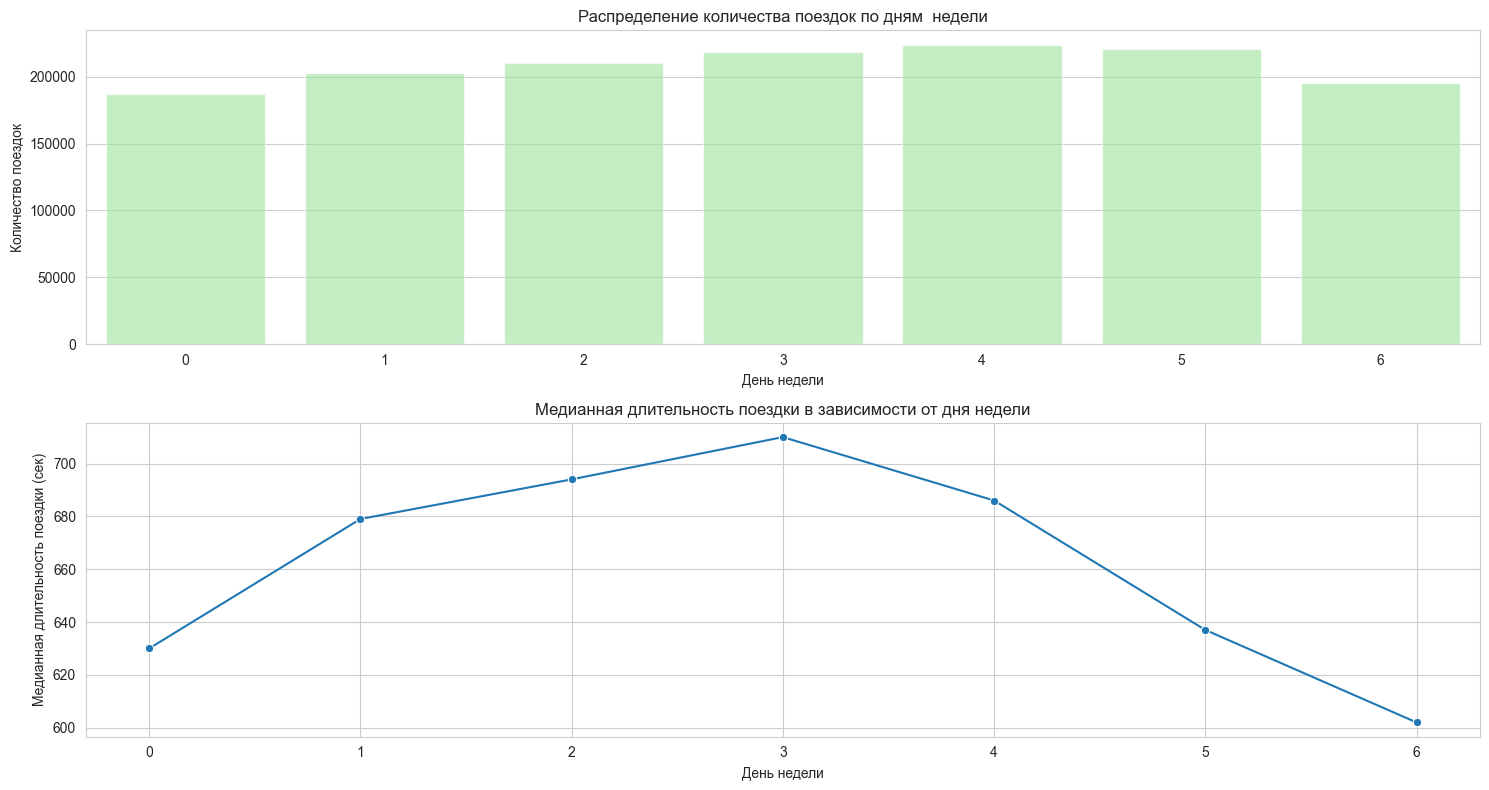

In [84]:
# ваш код здесь

# Вычисляем медианную длительность поездки для дня недели 
median_by_hour = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().reset_index()
median_by_hour.columns = ['pickup_day_of_week', 'median_duration']

# Создаём фигуру с двумя подграфиками
fig, axes= plt.subplots(2,1, figsize=(15,8))

# 1. Распределение количества поездок по часам

sns.countplot(data=taxi_data, x='pickup_day_of_week', color='lightgreen', alpha=0.6, ax=axes[0])
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество поездок')
axes[0].set_title('Распределение количества поездок по дням  недели')

# 2. Зависимость медианной длительности от часа
# sns.barplot(data=median_by_hour, x='pickup_day_of_week', y='median_duration', color='lightblue', ax=axes[1])
sns.lineplot(data=median_by_hour, x='pickup_day_of_week', y='median_duration', marker='o', ax=axes[1])
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Медианная длительность поездки (сек)')
axes[1].set_title('Медианная длительность поездки в зависимости от дня недели')



plt.tight_layout()
plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

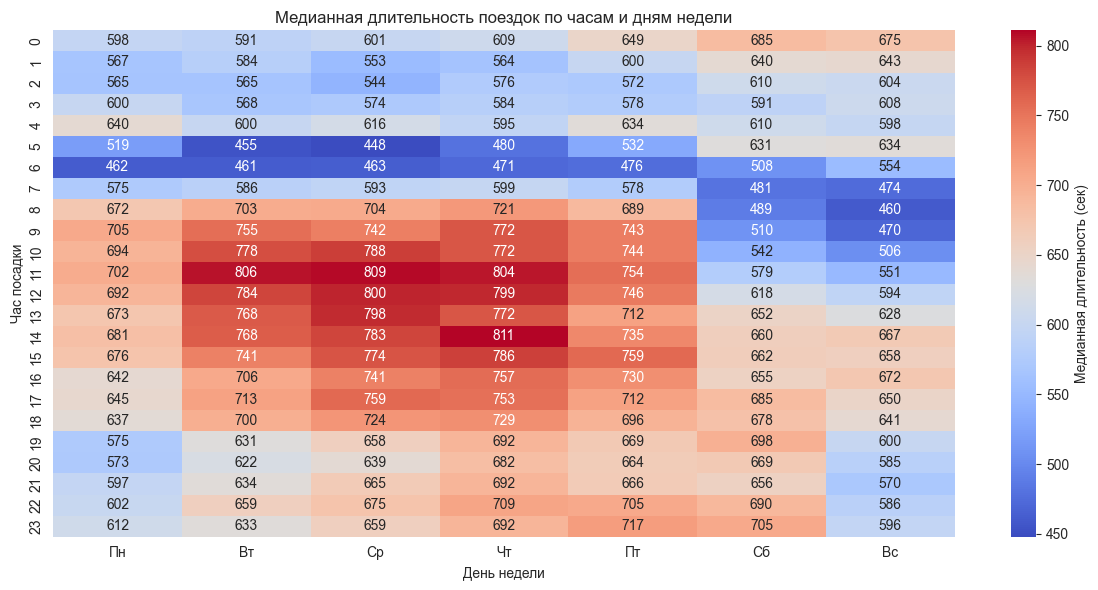

In [85]:
# ваш код здесь

# Сводная таблица
pivot = taxi_data.pivot_table(
    index='pickup_hour',
    columns='pickup_day_of_week',
    values='trip_duration',
    aggfunc='median'
)

# Переупорядочим дни, чтобы они шли с понедельника по воскресенье
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
pivot.columns = days 
pivot = pivot[days]

# Тепловая карта
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='coolwarm',
            cbar_kws={'label': 'Медианная длительность (сек)'})
plt.title('Медианная длительность поездок по часам и дням недели')
plt.xlabel('День недели')
plt.ylabel('Час посадки')
plt.tight_layout()
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


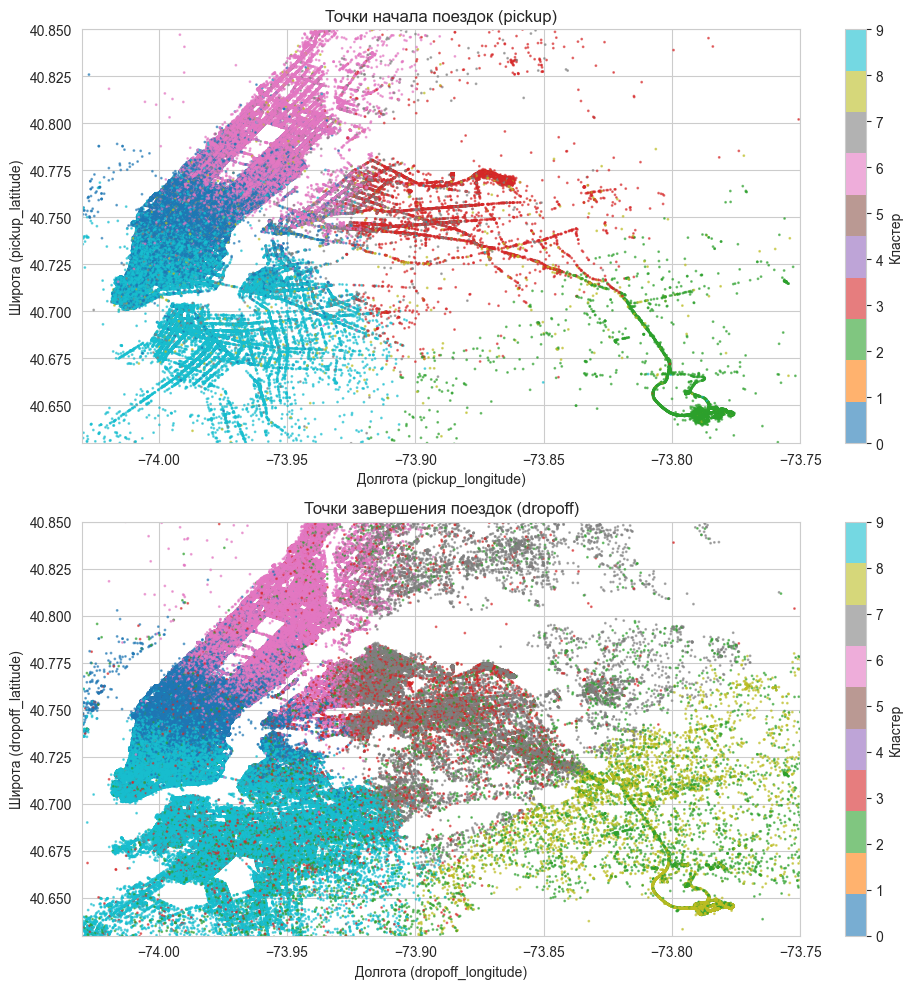

In [86]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# ваш код здесь

# Создаём фигуру с двумя подграфиками
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# точки начала поездок
sc1 = axes[0].scatter(
    x=taxi_data['pickup_longitude'],
    y=taxi_data['pickup_latitude'],
    c=taxi_data['geo_cluster'],       # цвет по кластерам
    cmap='tab10',                      # палитра для категорий (до 10 кластеров)
    s=1,                                # маленький размер точек
    alpha=0.6                           # полупрозрачность для лучшей видимости
)
axes[0].set_xlim(city_long_border)
axes[0].set_ylim(city_lat_border)
axes[0].set_xlabel('Долгота (pickup_longitude)')
axes[0].set_ylabel('Широта (pickup_latitude)')
axes[0].set_title('Точки начала поездок (pickup)')

# Добавляем легенду для кластеров
cbar = plt.colorbar(sc1, ax=axes[0], ticks=range(10))
cbar.set_label('Кластер')

#точки завершения поездок
sc2 = axes[1].scatter(
    x=taxi_data['dropoff_longitude'],
    y=taxi_data['dropoff_latitude'],
    c=taxi_data['geo_cluster'],
    cmap='tab10',
    s=1,
    alpha=0.6
)
axes[1].set_xlim(city_long_border)
axes[1].set_ylim(city_lat_border)
axes[1].set_xlabel('Долгота (dropoff_longitude)')
axes[1].set_ylabel('Широта (dropoff_latitude)')
axes[1].set_title('Точки завершения поездок (dropoff)')
cbar2 = plt.colorbar(sc2, ax=axes[1], ticks=range(10))
cbar2.set_label('Кластер')

plt.tight_layout()
plt.show()


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [87]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [88]:
train_data = taxi_data.copy()
train_data.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [89]:
# ваш код здесь
drop_columns = ['id', 'dropoff_datetime']
train_data= train_data.drop(drop_columns, axis=1)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1458233 non-null  int64         
 1   pickup_datetime     1458233 non-null  datetime64[ns]
 2   passenger_count     1458233 non-null  int64         
 3   pickup_longitude    1458233 non-null  float64       
 4   pickup_latitude     1458233 non-null  float64       
 5   dropoff_longitude   1458233 non-null  float64       
 6   dropoff_latitude    1458233 non-null  float64       
 7   store_and_fwd_flag  1458233 non-null  object        
 8   trip_duration       1458233 non-null  int64         
 9   pickup_date         1458233 non-null  object        
 10  pickup_hour         1458233 non-null  int32         
 11  pickup_day_of_week  1458233 non-null  int32         
 12  pickup_holiday      1458233 non-null  int32         
 13  total_distance   

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [90]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [91]:
# ваш код здесь

train_data['vendor_id']= train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

train_data['store_and_fwd_flag']= train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print('Cреднее по закодированному столбцу vendor_id', round(train_data['vendor_id'].mean(), 2))
print('Cреднее по закодированному столбцу store_and_fwd_flag', round(train_data['store_and_fwd_flag'].mean(),3))

Cреднее по закодированному столбцу vendor_id 0.53
Cреднее по закодированному столбцу store_and_fwd_flag 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [92]:
# ваш код здесь

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Выбираем нужные столбцы
features = ['pickup_day_of_week', 'geo_cluster', 'events']
data_to_encode = train_data[features]

# Создаём и обучаем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
# sparse_output=False возвращает обычный numpy-массив (удобно для DataFrame)
encoded_array = one_hot_encoder.fit_transform(data_to_encode)

# Получаем имена новых столбцов
column_names = one_hot_encoder.get_feature_names_out(features)

# Создаём итоговый DataFrame
data_onehot = pd.DataFrame(encoded_array, columns=column_names)

# Посмотрим результат

print(f"Количество бинарных столбцов: {data_onehot.shape[1]}")

Количество бинарных столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [93]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458233 non-null  int64  
 1   passenger_count     1458233 non-null  int64  
 2   pickup_longitude    1458233 non-null  float64
 3   pickup_latitude     1458233 non-null  float64
 4   dropoff_longitude   1458233 non-null  float64
 5   dropoff_latitude    1458233 non-null  float64
 6   store_and_fwd_flag  1458233 non-null  int64  
 7   trip_duration       1458233 non-null  int64  
 8   pickup_hour         1458233 non-null  int32  
 9   pickup_day_of_week  1458233 non-null  int32  
 10  pickup_holiday      1458233 non-null  int32  
 11  total_distance      1458233 non-null  float64
 12  total_travel_time   1458233 non-null  float64
 13  number_of_steps     1458233 non-null  float64
 14  haversine_distance  1458233 non-null  float64
 15  direction           

In [94]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(features, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))
train_data

Shape of data: (1458233, 38)


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_holiday,...,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458228,1,4,-73.982201,40.745522,-73.994911,40.740170,0,778,13,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458229,0,1,-74.000946,40.747379,-73.970184,40.796547,0,655,7,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458230,1,1,-73.959129,40.768799,-74.004433,40.707371,0,764,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1458231,0,1,-73.982079,40.749062,-73.974632,40.757107,0,373,15,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [95]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [96]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [97]:
# ваш код здесь
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd


# Отбираем 25 лучших числовых признаков
selector = SelectKBest(score_func=f_regression, k=25)
X_train_selected = selector.fit_transform(X_train, y_train_log)
X_valid_selected = selector.transform(X_valid)

# Получаем булеву маску: True – признак отобран, False – не отобран
selected_mask = selector.get_support()

# Получаем имена отобранных признаков
selected_features = X_train.columns[selected_mask].tolist()

print("Список отобранных 25 признаков:")
print(selected_features)

Список отобранных 25 признаков:
['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'temperature', 'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3', 'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [98]:
# ваш код здесь
from sklearn.preprocessing import MinMaxScaler


# Нормализация данных
scaler = MinMaxScaler()
X_train_normal = scaler.fit_transform(X_train_selected)
X_valid_normal = scaler.transform(X_valid_selected)

# Расчёт среднего для первого предиктора в валидационной выборке
mean_value = np.mean(X_valid_normal[:, 0])

print('Среднее для первого предиктора (валидация):', round(mean_value, 2))

Среднее для первого предиктора (валидация): 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [99]:
# ваш код здесь
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Обучение модели
linear_model = LinearRegression()
linear_model.fit(X_train_normal, y_train_log)

# Предсказания в логарифмическом масштабе
y_train_log_pred = linear_model.predict(X_train_normal)
y_valid_log_pred = linear_model.predict(X_valid_normal)

# Расчёт RMSLE как RMSE на логарифмированных значениях
rmsle_train_lr = np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid_lr = np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке: {:.2f}'.format(rmsle_train_lr))
print('RMSLE на валидационной выборке: {:.2f}'.format(rmsle_valid_lr))



RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [100]:
# ваш код здесь
from sklearn.preprocessing import PolynomialFeatures


# 1. Генерация полиномиальных признаков 2-й степени
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_normal)   # обучающая выборка
X_valid_poly = poly.transform(X_valid_normal)       # валидационная

# 2. Обучение линейной регрессии на полиномиальных признаках
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_log)

# 3. Предсказания в логарифмическом масштабе
y_train_log_pred = model_poly.predict(X_train_poly)
y_valid_log_pred = model_poly.predict(X_valid_poly)

# 4. Расчёт RMSLE (как RMSE на логарифмированных значениях)
rmsle_train_poly = np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid_poly  = np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке (полиномиальная регрессия): {:.2f}'.format(rmsle_train_poly))
print('RMSLE на валидационной выборке (полиномиальная регрессия): {:.2f}'.format(rmsle_valid_poly))

RMSLE на тренировочной выборке (полиномиальная регрессия): 0.47
RMSLE на валидационной выборке (полиномиальная регрессия): 0.69


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [101]:
# ваш код здесь
# Модели линейной регрессии
from sklearn.linear_model import LinearRegression, Ridge
ridge_lr_poly= Ridge(alpha=1)

# 2. Обучение линейной регрессии на полиномиальных признаках

ridge_lr_poly.fit(X_train_poly, y_train_log)

# 3. Предсказания в логарифмическом масштабе
y_train_log_ = ridge_lr_poly.predict(X_train_poly)
y_valid_log_pred = ridge_lr_poly.predict(X_valid_poly)

# 4. Расчёт RMSLE (как RMSE на логарифмированных значениях)
rmsle_train_poly_r = np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid_poly_r = np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке (полиномиальная регрессия): {:.2f}'.format(rmsle_train_poly_r))
print('RMSLE на валидационной выборке (полиномиальная регрессия): {:.2f}'.format(rmsle_valid_poly_r))

RMSLE на тренировочной выборке (полиномиальная регрессия): 0.47
RMSLE на валидационной выборке (полиномиальная регрессия): 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [102]:
# ваш код здесь
# from sklearn.tree import DecisionTreeRegressor

# # создаем обьект класса DecisionTreeRegressor
# Dtree_model= DecisionTreeRegressor()

# # обучаем модель
# Dtree_model.fit(X_train_normal, y_train_log)
# #  делаем предскаазния
# y_train_log_pred= Dtree_model.predict(X_train_normal)
# y_valid_log_pred= Dtree_model.predict(X_valid_normal)



# # 4. Расчёт RMSLE (как RMSE на логарифмированных значениях)
# rmsle_train_dtr = np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))
# rmsle_valid_dtr = np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))

# print('RMSLE на тренировочной выборке (дерево решений): {:.2f}'.format(rmsle_train_dtr))
# print('RMSLE на валидационной выборке (дерево решений): {:.2f}'.format(rmsle_valid_dtr))

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [103]:
# ваш код здесь
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import matplotlib.pyplot as plt

# max_depths = range(7, 21)  # от 7 до 20 включительно
# train_rmsle = []
# valid_rmsle = []
# # создаем цикл для перебирания макс глубины 
# for depth in max_depths:
#     # создаем обьект класса DecisionTreeRegressor
#     model = DecisionTreeRegressor(max_depth=depth, random_state=42)
#     # обучаем модель
#     model.fit(X_train_normal, y_train_log)
#     # делаем предсказания
#     y_train_pred = model.predict(X_train_normal)
#     y_valid_pred = model.predict(X_valid_normal)
    
#     # Вычисляем RMSLE как корень из MSE логарифмированных значений
#     train_rmsle.append(np.sqrt(mean_squared_error(y_train_log, y_train_pred)))
#     valid_rmsle.append(np.sqrt(mean_squared_error(y_valid_log, y_valid_pred)))

# # Построение графиков
# plt.figure(figsize=(10,6))
# plt.plot(max_depths, train_rmsle, label='Train RMSLE', marker='o')
# plt.plot(max_depths, valid_rmsle, label='Validation RMSLE', marker='o')
# plt.xlabel('Max Depth')
# plt.ylabel('RMSLE')
# plt.title('Зависимость RMSLE от глубины дерева')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Поиск оптимальной глубины: глубина с минимальной валидационной ошибкой
# optimal_depth_index = np.argmin(valid_rmsle)
# optimal_depth = max_depths[optimal_depth_index]
# optimal_train_rmsle = train_rmsle[optimal_depth_index]
# optimal_valid_rmsle = valid_rmsle[optimal_depth_index]

# print(f'Оптимальная глубина: {optimal_depth}')
# print('RMSLE на тренировочной выборке: {:.2f}'.format(optimal_train_rmsle))
# print('RMSLE на валидационной выборке: {:.2f}'.format(optimal_valid_rmsle))

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [104]:
# # ваш код здесь
# # создаем обьект класса RandomForestRegressor
# random_tree_model= ensemble.RandomForestRegressor(n_estimators=200,
#     max_depth=12,
#     criterion='squared_error',
#     min_samples_split=20,
#     random_state=42
#     )

# # обучаем модель
# random_tree_model.fit(X_train_normal, y_train_log)
# y_train_pred = random_tree_model.predict(X_train_normal)
# y_valid_pred = random_tree_model.predict(X_valid_normal)
    
# # Вычисляем RMSLE как корень из MSE логарифмированных значений
# rmsle_train_rt = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
# rmsle_valid_rt = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

# print('RMSLE на тренировочной выборке (полиномиальная регрессия): {:.2f}'.format(rmsle_train_rt))
# print('RMSLE на валидационной выборке (полиномиальная регрессия): {:.2f}'.format(rmsle_valid_rt))

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [105]:
# ваш код здесь
gb=ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6, 
    min_samples_split=30,
    random_state=42
    )


# обучаем модель
gb.fit(X_train_normal, y_train_log)
y_train_pred_gb= gb.predict(X_train_normal)
y_valid_pred_gb = gb.predict(X_valid_normal)
    
# Вычисляем RMSLE как корень из MSE логарифмированных значений
rmsle_train_gr = np.sqrt(mean_squared_error(y_train_log, y_train_pred_gb))
rmsle_valid_gr = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_gb))

print('RMSLE на тренировочной выборке (GradientBoostingRegressor): {:.2f}'.format(rmsle_train_gr))
print('RMSLE на валидационной выборке (GradientBoostingRegressor): {:.2f}'.format(rmsle_valid_gr))

RMSLE на тренировочной выборке (GradientBoostingRegressor): 0.37
RMSLE на валидационной выборке (GradientBoostingRegressor): 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?

* Градиентный бустинг над деревьями решений показал наилучший результат ( 0.37 и 0.39). Минимальный разрры между результатми тренировочной и валидационой выборке говорит что модель не переобучается 


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [106]:
# # ваш код здесь

# import matplotlib.pyplot as plt
# import numpy as np

# # Получаем важность признаков из обученной модели gb
# feature_importance = gb.feature_importances_

# # Сортируем признаки по убыванию важности
# sorted_idx = np.argsort(feature_importance)[::-1]
# sorted_features = [selected_features[i] for i in sorted_idx]
# sorted_importance = feature_importance[sorted_idx]

# # Выводим топ-3
# print("Топ-3 наиболее значимых признака:")
# for i in range(3):
#     print(f"{i+1}. {sorted_features[i]} (важность: {sorted_importance[i]:.4f})")

# # Построение столбчатой диаграммы
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(sorted_importance[:25])), sorted_importance[:25][::-1], tick_label=sorted_features[:25][::-1])
# plt.xlabel('Важность')
# plt.title('Топ важности признаков в Gradient Boosting')
# plt.gca().invert_yaxis()  # чтобы самый важный был сверху
# plt.tight_layout()
# plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [107]:
# # ваш код здесь
# from sklearn.metrics import median_absolute_error

# # Восстанавливаем значения в минутах
# y_valid_orig = np.expm1(y_valid_log)
# y_valid_pred_orig = np.expm1(y_valid_pred_gb)

# # Вычисляем MeAE
# meae = median_absolute_error(y_valid_orig, y_valid_pred_orig) /60

# # Округляем до десятых
# print(f"MeAE на валидационной выборке (в минутах): {meae:.1f}")

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [108]:
test_data = pd.read_csv("Project5_test_data.csv")
osrm_data_test = pd.read_csv("Project5_osrm_data_test.csv")
test_id = test_data['id']


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [109]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data,osrm_data_test)
test_data = add_geographical_features(test_data)

coords = np.hstack((test_data[['pickup_latitude', 'pickup_longitude']],
                    test_data[['dropoff_latitude', 'dropoff_longitude']]))
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

test_data = add_cluster_features(test_data, kmeans)

test_data = add_weather_features(test_data, weather_data)


In [110]:
test_data = fill_null_weather_data(test_data)


In [111]:

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)


In [ ]:
# Выбираем нужные столбцы
data_to_encode = test_data[features]
 
# Создаём и обучаем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
# sparse_output=False возвращает обычный numpy-массив (удобно для DataFrame)
encoded_array = one_hot_encoder.fit_transform(data_to_encode)

# Получаем имена новых столбцов
column_names = one_hot_encoder.get_feature_names_out(features)

# Создаём итоговый DataFrame
data_onehot = pd.DataFrame(encoded_array, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(features, axis=1), data_onehot], 
    axis=1)


In [113]:
X_test = test_data[selected_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


d:\idi\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [115]:
# ваш код здесь
# получаем предсказания в логарифмическом масштабе
y_test_log_pred = gb.predict(X_test_scaled)

# Преобразуем обратно в исходные минуты (exp(z) - 1)
y_test_pred = np.expm1(y_test_log_pred)   # эквивалентно np.exp(y_test_log_pred) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv('submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [116]:
!pip install xgboost


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


После чего модуль можно импортировать:

In [117]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [118]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_normal, label=y_train_log, feature_names=selected_features)
dvalid = xgb.DMatrix(X_valid_normal, label=y_valid_log, feature_names=selected_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [119]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74193
[10]	train-rmse:0.49100	valid-rmse:0.49357
[20]	train-rmse:0.44093	valid-rmse:0.44375
[30]	train-rmse:0.42613	valid-rmse:0.42914
[40]	train-rmse:0.41868	valid-rmse:0.42183
[50]	train-rmse:0.41332	valid-rmse:0.41675
[60]	train-rmse:0.40980	valid-rmse:0.41347
[70]	train-rmse:0.40686	valid-rmse:0.41075
[80]	train-rmse:0.40427	valid-rmse:0.40854
[90]	train-rmse:0.40243	valid-rmse:0.40702
[100]	train-rmse:0.40069	valid-rmse:0.40561
[110]	train-rmse:0.39934	valid-rmse:0.40453
[120]	train-rmse:0.39780	valid-rmse:0.40328
[130]	train-rmse:0.39629	valid-rmse:0.40208
[140]	train-rmse:0.39528	valid-rmse:0.40127
[150]	train-rmse:0.39413	valid-rmse:0.40040
[160]	train-rmse:0.39303	valid-rmse:0.39957
[170]	train-rmse:0.39219	valid-rmse:0.39897
[180]	train-rmse:0.39136	valid-rmse:0.39843
[190]	train-rmse:0.39066	valid-rmse:0.39800
[200]	train-rmse:0.38988	valid-rmse:0.39760
[210]	train-rmse:0.38926	valid-rmse:0.39721
[220]	train-rmse:0.38847	valid-rmse:0.39668

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [120]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39455


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

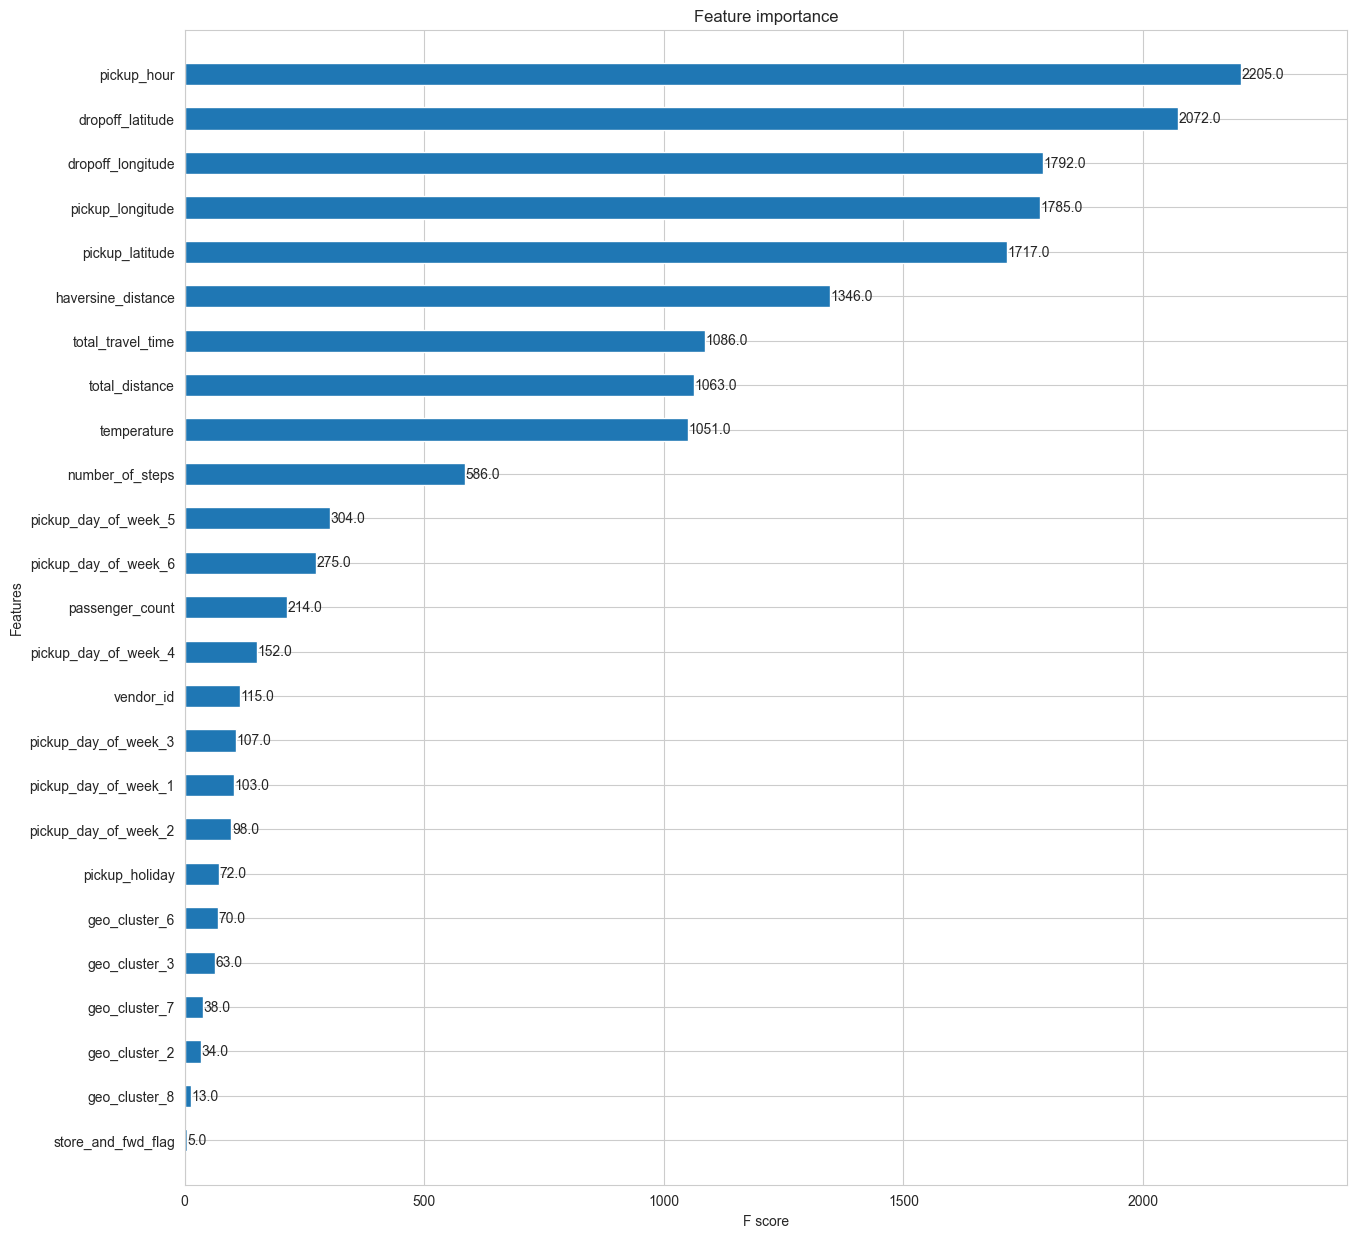

In [121]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)